In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.integrate import solve_ivp
from tqdm import tqdm
# numpy.linalg is also an option for even fewer dependencies

Text(0.5, 1.0, 'A sample of data')

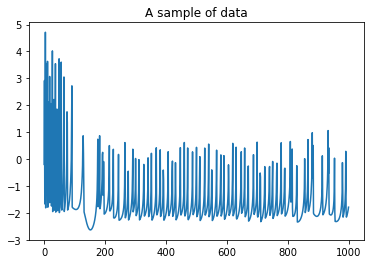

In [11]:
# load the data
trainLen = 1250000
testLen = 249999
initLen = 0
data = np.load("data/DK_time_series_3000000.npy")

# plot some of it
plt.figure(10).clear()
plt.plot(data[:1000])
plt.title('A sample of data')

In [12]:
def amp_to_int(x, n=256):
    ### x.min must be negative
    step = (x.max() - x.min()) / n
    ans = np.zeros_like(x)
    for i, val in enumerate(np.arange(x.min(), x.max(), step)):
        for j in range(len(x)):
            if val <= x[j] < val + step:
                ans[j] = i
                
    return ans


def int_to_amp(x, x_true, n=256):
    ### x.min must be negative
    step = (x_true.max() - x_true.min()) / n
    ans = np.zeros_like(x, dtype=float)
    #for j in range(len(x)):
    ans = x_true.min() + x * step
                
    return ans        
    

In [13]:
def one_hot(x, num_channels=256):
    x_o = np.zeros((256, len(x)), dtype="int")
    for i in tqdm(list(range(len(x)))):
        x_o[int(x[i]), i] = 1
    return x_o

In [14]:
data_o = one_hot(amp_to_int(data))

100%|███████████████████████████████████████████████████████████████████| 3000000/3000000 [00:02<00:00, 1399560.14it/s]


In [15]:
#np.save("bin_data", data_o)

In [16]:
def ReservoirComputings(data, true_data, a=0.5, size=400, spectral_radius=0.001):



    # generate the ESN reservoir
    inSize = outSize = 256
    resSize = size
#     a = 0.5 # leaking rate
    np.random.seed(42)
    Win = (np.random.rand(resSize,inSize) - 0.5) * 1
    W = (np.random.rand(resSize,resSize) - 0.5) * 2 
    for i in range(resSize):
        W[i][i] = 0
    # normalizing and setting spectral radius (correct, slow):
    print('Computing spectral radius...')
    rhoW = max(abs(linalg.eig(W)[0]))
    print('done.')
    W *= spectral_radius / rhoW

    # allocated memory for the design (collected states) matrix
    X = np.zeros((inSize+resSize,trainLen-initLen))
    # set the corresponding target matrix directly
    Yt = data[None,initLen+1:trainLen+1] 

    # run the reservoir with the data and collect X
    x = np.zeros((resSize,1))
    for t in tqdm(range(trainLen)):
        u = data[t]
        
        x = (1-a)*x + a*np.tanh(np.dot(Win, u).reshape((resSize,1)) + np.dot( W, x ) )
        
        if t >= initLen:
            X[:,t-initLen] = np.concatenate((u.reshape((inSize, 1)),x))[:,0]
    reservoir_end = x 
    # train the output by ridge regression
    reg = 1e-8  # regularization coefficient
    # direct equations from texts:
    #X_T = X.T
    #Wout = np.dot( np.dot(Yt,X_T), linalg.inv( np.dot(X,X_T) + \
    #    reg*np.eye(1+inSize+resSize) ) )
    # using scipy.linalg.solve:
    Wout = linalg.solve( np.dot(X,X.T) + reg*np.eye(inSize+resSize), 
        np.dot(X,Yt.T)).T

    # run the trained ESN in a generative mode. no need to initialize here, 
    # because x is initialized with training data and we continue from there.
    Y = np.zeros((outSize,testLen))
    u = data[trainLen]
    for t in tqdm(range(testLen)):
        x = (1-a)*x + a*np.tanh(np.dot(Win, u).reshape((resSize,1)) + np.dot( W, x ) )
        y = np.dot( Wout, np.concatenate((u.reshape((inSize, 1)),x)) )[0, :, 0]
        Y[:,t] = np.argmax(y)
        # generative mode:
        #u = y
        ## this would be a predictive mode:
        u = data[trainLen+t+1] 
        
    # compute MSE for the first errorLen time steps
    errorLen = testLen
    mse = sum( np.square( true_data[trainLen+1:trainLen+errorLen+1] - 
        int_to_amp(Y[0,0:errorLen], true_data) ) ) / errorLen
    print('MSE = ' + str( mse ))
    
    return (mse, reservoir_end, Wout, Win, W)

    # # plot some signals
    # plt.figure(1).clear()
    # plt.plot( data[trainLen+1:trainLen+testLen+1], 'g' )
    # plt.plot( Y.T, 'b' )
    # plt.title('Target and generated signals $y(n)$ starting at $n=0$')
    # plt.legend(['Target signal', 'Free-running predicted signal'])

    # plt.figure(2).clear()
    # plt.plot( X[0:20,0:200].T )
    # plt.title(r'Some reservoir activations $\mathbf{x}(n)$')

    # plt.figure(3).clear()
    # plt.bar( np.arange(1+inSize+resSize), Wout[0].T )
    # plt.title(r'Output weights $\mathbf{W}^{out}$')

    # plt.show()

In [7]:
res1, reservoir_end, Wout, Win, W = ReservoirComputings(data_o.T)

Computing spectral radius...
done.


100%|█████████████████████████████████████████████████████████████████████| 1250000/1250000 [01:25<00:00, 14686.59it/s]


In [15]:
parameters = {"a":[0.2, 0.4, 0.6, 0.8], "size":[400, 1000], "spectral_radius":[0.001, 0.01]}

In [16]:
results = []
for a in parameters["a"]:
    for size in parameters["size"]:
        for sr in parameters["spectral_radius"]:
            print("sr=", sr)
            print("size=", size)
            print("a=", a)
            
            results.append([ReservoirComputings(data_o.T, data, a, size, sr)])

sr= 0.001
size= 400
a= 0.2
Computing spectral radius...
done.


100%|████████████████████████████████████████████████████████████████████████| 249999/249999 [00:26<00:00, 9508.26it/s]


MSE = 0.24076625062610676
sr= 0.01
size= 400
a= 0.2
Computing spectral radius...
done.


100%|████████████████████████████████████████████████████████████████████████| 249999/249999 [00:25<00:00, 9839.48it/s]


MSE = 0.24049387407108605
sr= 0.001
size= 1000
a= 0.2
Computing spectral radius...
done.


100%|████████████████████████████████████████████████████████████████████████| 249999/249999 [02:00<00:00, 2080.18it/s]


MSE = 0.3054384008071665
sr= 0.01
size= 1000
a= 0.2
Computing spectral radius...
done.


100%|████████████████████████████████████████████████████████████████████████| 249999/249999 [01:48<00:00, 2313.82it/s]


MSE = 0.3069404017997643
sr= 0.001
size= 400
a= 0.4
Computing spectral radius...
done.


100%|████████████████████████████████████████████████████████████████████████| 249999/249999 [00:25<00:00, 9673.58it/s]


MSE = 0.32399494200320017
sr= 0.01
size= 400
a= 0.4
Computing spectral radius...
done.


100%|████████████████████████████████████████████████████████████████████████| 249999/249999 [00:25<00:00, 9667.14it/s]


MSE = 0.32378110125057463
sr= 0.001
size= 1000
a= 0.4
Computing spectral radius...
done.


100%|████████████████████████████████████████████████████████████████████████| 249999/249999 [01:46<00:00, 2345.23it/s]


MSE = 0.30324723571404616
sr= 0.01
size= 1000
a= 0.4
Computing spectral radius...
done.


100%|████████████████████████████████████████████████████████████████████████| 249999/249999 [01:53<00:00, 2193.79it/s]


MSE = 0.30521853126829057
sr= 0.001
size= 400
a= 0.6
Computing spectral radius...
done.


100%|████████████████████████████████████████████████████████████████████████| 249999/249999 [00:25<00:00, 9904.60it/s]


MSE = 0.36982955160962033
sr= 0.01
size= 400
a= 0.6
Computing spectral radius...
done.


100%|████████████████████████████████████████████████████████████████████████| 249999/249999 [00:25<00:00, 9942.22it/s]


MSE = 0.3696859956525391
sr= 0.001
size= 1000
a= 0.6
Computing spectral radius...
done.


100%|██████████████████████████████████████████████████████████████████████| 1250000/1250000 [05:23<00:00, 3866.46it/s]


MemoryError: Unable to allocate 2.38 GiB for an array with shape (256, 1250000, 1) and data type float64

In [7]:
parameters = {"a":[0.6, 0.8], "size":[400, 1000], "spectral_radius":[0.001, 0.01]}

In [ ]:
results = []
for a in parameters["a"]:
    for size in parameters["size"]:
        for sr in parameters["spectral_radius"]:
            print("sr=", sr)
            print("size=", size)
            print("a=", a)
            
            results.append([ReservoirComputings(data_o.T, data, a, size, sr)])

sr= 0.001
size= 400
a= 0.6
Computing spectral radius...
done.


100%|████████████████████████████████████████████████████████████████████████| 249999/249999 [00:25<00:00, 9932.15it/s]


MSE = 0.36982955160962033
sr= 0.01
size= 400
a= 0.6
Computing spectral radius...
done.


100%|████████████████████████████████████████████████████████████████████████| 249999/249999 [00:25<00:00, 9828.65it/s]


MSE = 0.3696859956525391
sr= 0.001
size= 1000
a= 0.6
Computing spectral radius...
done.


100%|████████████████████████████████████████████████████████████████████████| 249999/249999 [01:12<00:00, 3461.72it/s]


MSE = 0.26440493961025713
sr= 0.01
size= 1000
a= 0.6
Computing spectral radius...
done.


100%|████████████████████████████████████████████████████████████████████████| 249999/249999 [01:56<00:00, 2149.88it/s]


MSE = 0.26630999566182034
sr= 0.001
size= 400
a= 0.8
Computing spectral radius...
done.


100%|████████████████████████████████████████████████████████████████████████| 249999/249999 [00:26<00:00, 9529.16it/s]


MSE = 0.3745905218965038
sr= 0.01
size= 400
a= 0.8
Computing spectral radius...
done.


100%|████████████████████████████████████████████████████████████████████████| 249999/249999 [00:26<00:00, 9529.01it/s]


MSE = 0.3733527980184817
sr= 0.001
size= 1000
a= 0.8
Computing spectral radius...
done.


 59%|█████████████████████████████████████████▌                             | 732124/1250000 [03:15<02:12, 3916.38it/s]

In [8]:
parameters = {"a":[0.8], "size":[1000], "spectral_radius":[0.001, 0.01]}

In [ ]:
results = []
for a in parameters["a"]:
    for size in parameters["size"]:
        for sr in parameters["spectral_radius"]:
            print("sr=", sr)
            print("size=", size)
            print("a=", a)
            
            results.append([ReservoirComputings(data_o.T, data, a, size, sr)])

sr= 0.001
size= 1000
a= 0.8
Computing spectral radius...
done.


100%|████████████████████████████████████████████████████████████████████████| 249999/249999 [02:09<00:00, 1923.43it/s]


MSE = 0.20653667441152074
sr= 0.01
size= 1000
a= 0.8
Computing spectral radius...
done.


 90%|███████████████████████████████████████████████████████████████       | 1125699/1250000 [04:57<00:32, 3794.93it/s]

In [17]:
parameters = {"a":[0.8], "size":[1000], "spectral_radius":[0.01]}

In [18]:
results = []
for a in parameters["a"]:
    for size in parameters["size"]:
        for sr in parameters["spectral_radius"]:
            print("sr=", sr)
            print("size=", size)
            print("a=", a)
            
            results.append([ReservoirComputings(data_o.T, data, a, size, sr)])

sr= 0.01
size= 1000
a= 0.8
Computing spectral radius...
done.


100%|████████████████████████████████████████████████████████████████████████| 249999/249999 [02:21<00:00, 1762.40it/s]


MSE = 0.20633303076957976


In [26]:
results[0][0][2].max()

45.063967212572926

In [31]:
# np.save("model/reservoir_end_bin", reservoir_end)
# np.save("model/Wout_bin", Wout)
# np.save("model/Win_bin", Win)
# np.save("model/W_bin", W)

In [27]:
_, reservoir_end, Wout, Win, W = results[0][0]

In [37]:
def GetRmseReservoir(reservoir_end, Wout, Win, W, data, a=0.8, size=1000, k=19):

    all_predicts = np.empty((k, 1))
    
    
    predicted_val = np.array([])
    
    r = reservoir_end
    
    resSize=size
    
    inSize = outSize = 256
    
    for t in tqdm(range(testLen)):
        all_predicts = np.concatenate((all_predicts, np.zeros((k, 1))), axis=1)

        u = data[trainLen+t]
        r = (1-a)*r + a*np.tanh(np.dot(Win, u).reshape((resSize,1)) + np.dot( W, r ) )
        cur_r = r
        cur_u = u
        for step in range(k):

            out = np.dot( Wout, np.concatenate((cur_u.reshape((inSize, 1)),cur_r)))[0, :, 0]
            all_predicts[step, -1] = np.argmax(out)
            cur_u = np.zeros_like(u)
            cur_u[np.argmax(out)] = 1
            cur_r = (1-a)*cur_r + a*np.tanh(np.dot(Win, cur_u).reshape((resSize,1)) + np.dot( W, cur_r ) )


    return all_predicts

In [38]:
all_predicts = GetRmseReservoir(reservoir_end, Wout, Win, W, data_o.T)

100%|████████████████████████████████████████████████████████████████████████| 249999/249999 [1:00:07<00:00, 69.30it/s]


In [10]:
#np.save('predicts/all_predicts_bin_res', all_predicts)

In [43]:
np.save('predicts/all_predicts_bin_res_best_params', all_predicts)

In [39]:
def CalcRMSE(x, y):
    return (((x - y)**2).mean())**0.5

In [40]:
res_bin_rmses = []
res_bin_rmses.append(CalcRMSE(int_to_amp(all_predicts[0][1:], data), data[trainLen+1:trainLen + testLen+1]))
for i in tqdm(range(1, 19)):
    res_bin_rmses.append(CalcRMSE(int_to_amp(all_predicts[i][1:], data, n=256)[:-i], data[trainLen+1+i:trainLen + testLen+1]))

100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.33it/s]


In [41]:
res_bin_rmses

[0.45423895778497325,
 0.4529140837886297,
 0.5120752799947261,
 0.5746794409021813,
 0.6117279057057589,
 0.7035415240333928,
 0.78470101315335,
 0.8450272417910758,
 0.8886806411309635,
 0.8867161071847558,
 0.8848106519331105,
 0.8867254877626963,
 0.9082672188291951,
 0.9079788197057427,
 0.9119564743357579,
 0.9118827906555556,
 0.9135734217158241,
 0.9219992619395389,
 0.916927034874414]

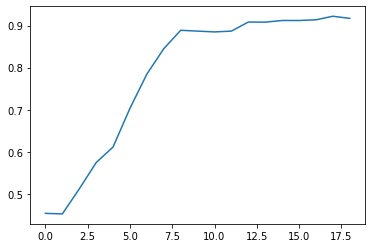

In [42]:
plt.plot(res_bin_rmses)

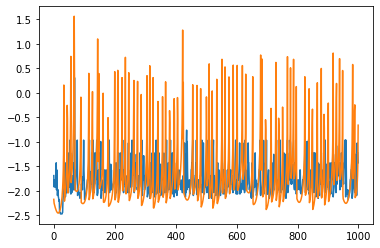

In [72]:
i = 10
plt.plot(int_to_amp(all_predicts[i][1:], data, n=256)[:-i][:1000])
plt.plot(data[trainLen+i:trainLen + testLen][:1000])

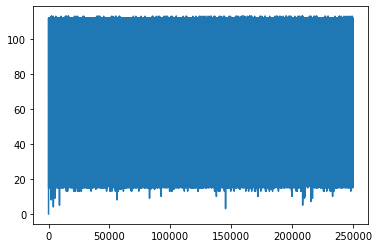

In [59]:
plt.plot(all_predicts[6])

In [64]:
def GetRMSE(reservoir_end, Wout, Win, W, data):
    a=0.5
    inSize = outSize = 256
    resSize = 400
    Y = np.zeros((outSize,testLen))
    u = data[trainLen]
    x = reservoir_end
    for t in tqdm(range(testLen)):
        x = (1-a)*x + a*np.tanh(np.dot(Win, u).reshape((resSize,1)) + np.dot( W, x ) )
        y = np.dot( Wout, np.concatenate((u.reshape((inSize, 1)),x)) )
        Y[:,t] = y[0, :, 0]
        # generative mode:
        #u = y
        ## this would be a predictive mode:
        u = data[trainLen+t+1] 
    return Y

In [65]:
res = GetRMSE(reservoir_end, Wout, Win, W, data_o.T)

100%|████████████████████████████████████████████████████████████████████████| 249999/249999 [00:27<00:00, 9189.18it/s]


In [67]:
CalcRMSE(int_to_amp(res.argmax(axis=0), data), data[trainLen:trainLen + testLen])

0.740712639272934

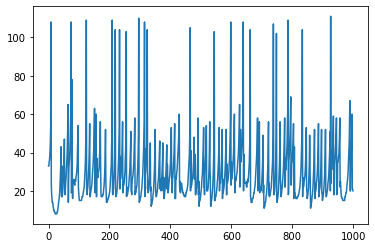

In [49]:
plt.plot(res.argmax(axis=0)[:1000])

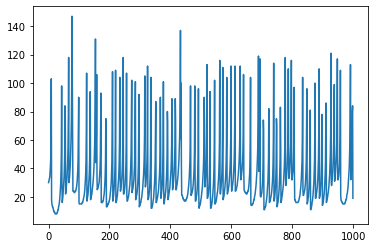

In [50]:
plt.plot((data_o).argmax(axis=0)[trainLen:trainLen + testLen][:1000])